# Overview
This notebook provides the ability to generate random droplet parameters, write them to disk, and 
train a neural network with said droplet parameters to approximate the underlying ODEs that govern 
the droplet parameters.  Once trained researchers can generate a Fortran 90 module that provides 
the ability to estimate droplet radius and temperature for some time in the future.  

The intent is that a small, reasonably trained neural network can provide accurate enough droplet 
characteristic estimations that are significantly faster than an iterative Gauss-Newton technique.
Initial testing indicates a small 4-layer network (roughly 2400 parameters) with Fortran 90 module
generated by this notebook is 30-90x faster than the existing (as of 2024/09/25) iterative approach 
which results in roughly a factor of 2x overall simulation speedup.

This notebook is broken down into the following sections:

1. ODEs of interest
2. Mapping data to/from $[-1, 1]$
3. Generating random droplets
4. Training a neural network
5. Analyzing a network's performance
6. Exporting a network to Fortran 90



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

from droplet_approximation import *

In [ ]:
# The notebook graphs the "worst" 5% of particle by NRMSE
# These five are picked based on the first model provided
# in `model_load_paths`. Each subsequent model will be evaluated
# on the same data, and will have an NRMSE calculated,
# but they will not be used to determine which particles to graph.


model_load_paths = ["../models/network_box_residual_l1_uniform_wide_epoch_14.pth"]

testing_data_file = "../data/error_analysis_particles.parquet"

commit_SHAs = ["369bacc0ba5c7367f17ec71707a1df64afd1b6f5"]

# Controls whether to do the graphing/analysis with iterative or direct inference
iterative = True 

# Good CUSUM parameters for iterative
cusum_error_tolerance = np.array( [ 0.02, 0.10 ] )
cusum_error_threshold = np.array( [ 0.08, 0.40 ] )

# Good CUSUM parameters for non-iterative
#cusum_error_tolerance = np.array( [ 0.005, 0.05 ] )
#cusum_error_threshold = np.array( [ 0.02, 0.20 ] )

norm = standard_norm

In [3]:
# This is to make it work with the current model. Remove if using a new model

set_parameter_ranges( { "radius": ( -6.75, -3.00 ),
                        "relative_humidity": ( 0.98, 1.11 )} )

In [4]:
model_count = len(model_load_paths)

model_names = [path.split( "/" )[-1].split( "." )[0].replace("_", " ") for path in model_load_paths]

models = [ResidualNet() for i in range(model_count)]

for i in range(model_count):
    models[i].load_state_dict( torch.load(model_load_paths[i]))

In [5]:
df = pd.read_parquet( testing_data_file )

In [6]:
droplet_parameter_list = [
    np.stack( df.iloc[i][[
        "input radii",
        "input temperatures",
        "salt masses",
        "air temperatures",
        "relative humidities",
        "air densities",
        "integration times"
    ]].to_numpy(), axis=-1 )
    for i in range(len( df ))
]
particle_ids = df.index.values


In [7]:
score_reports = [ ScoringReport( droplet_parameter_list, 
                                 particle_ids, 
                                 models[model_i], 
                                 model_names[model_i], 
                                 "cpu", 
                                 cusum_error_tolerance=cusum_error_tolerance, 
                                 cusum_error_threshold=cusum_error_threshold,
                                 iterative=iterative,
                                 norm=norm )
                  for model_i in range ( model_count ) ]

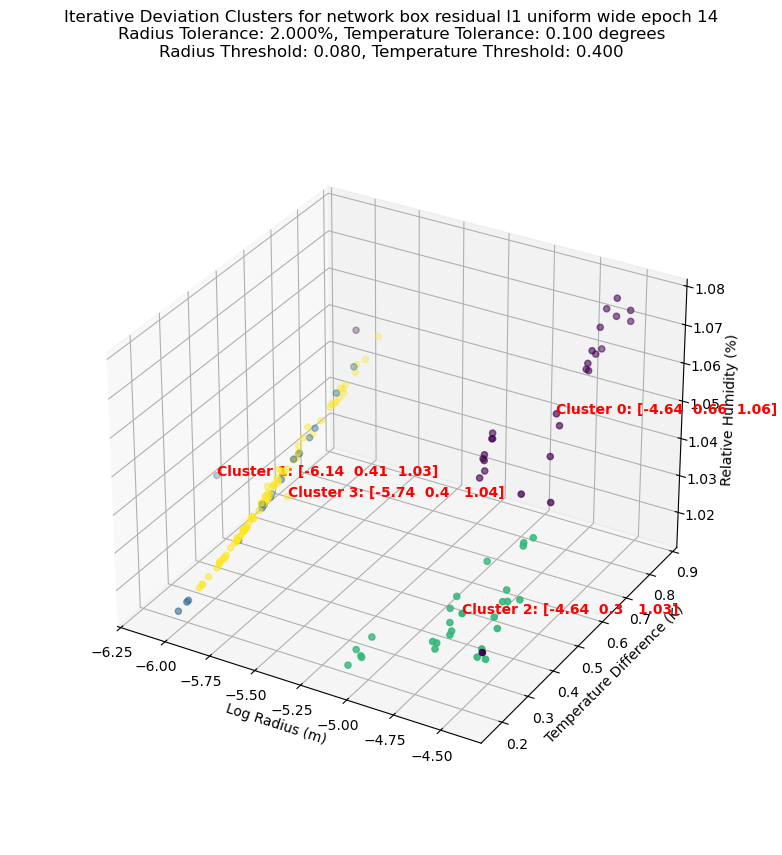

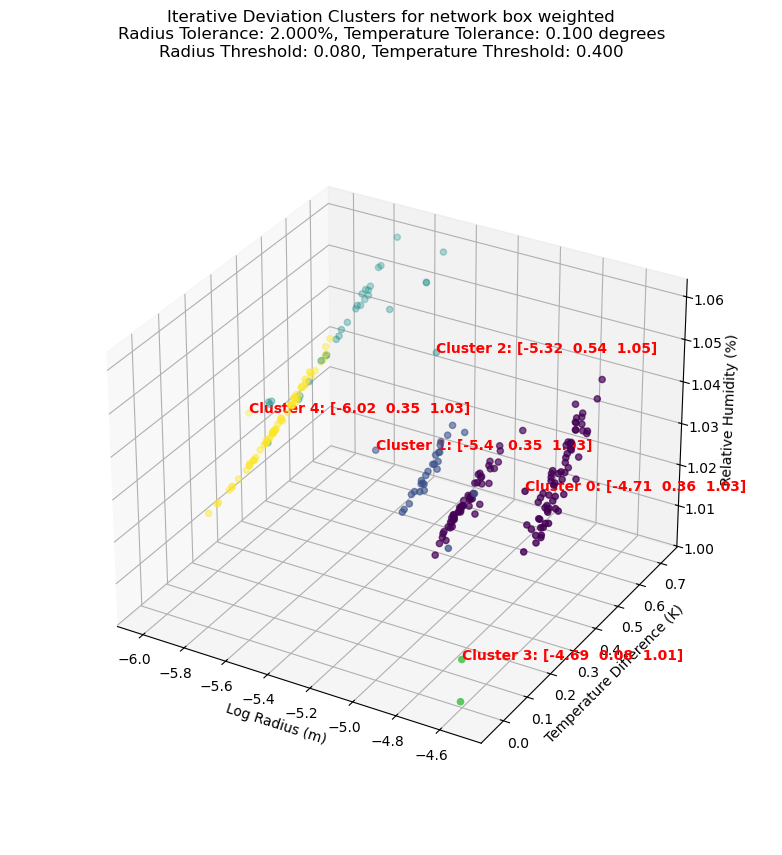

In [8]:
for score_report in score_reports:
    with np.printoptions(precision=2):
        fig,ax = score_report.plot_deviations()

    fig.set_size_inches((8,12))

In [9]:
# Sort DF based on first score report
df["nrmse"] = score_reports[0].per_particle_nrmse.values()

/tmp/ipykernel_1657926/284603479.py:140: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_h.show()
/tmp/ipykernel_1657926/284603479.py:140: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_h.show()


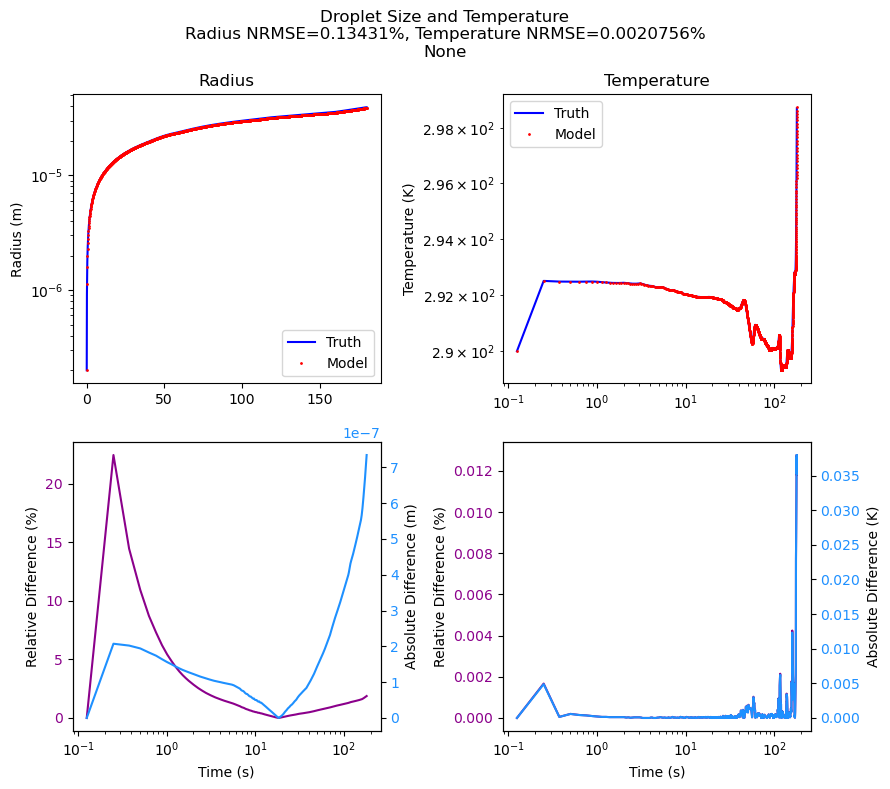

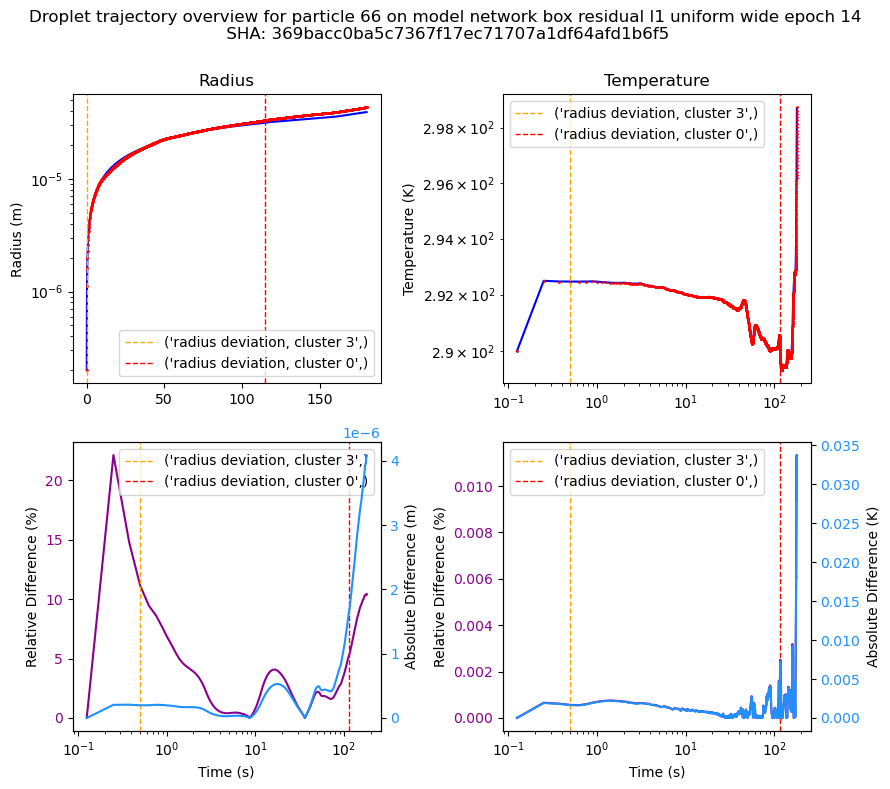

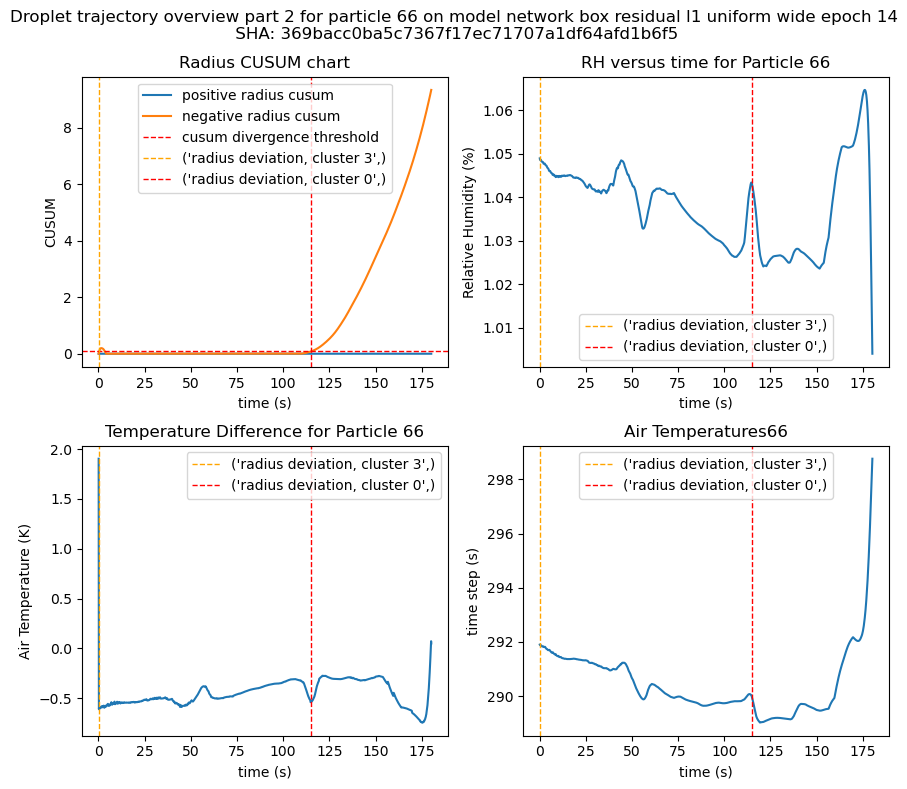

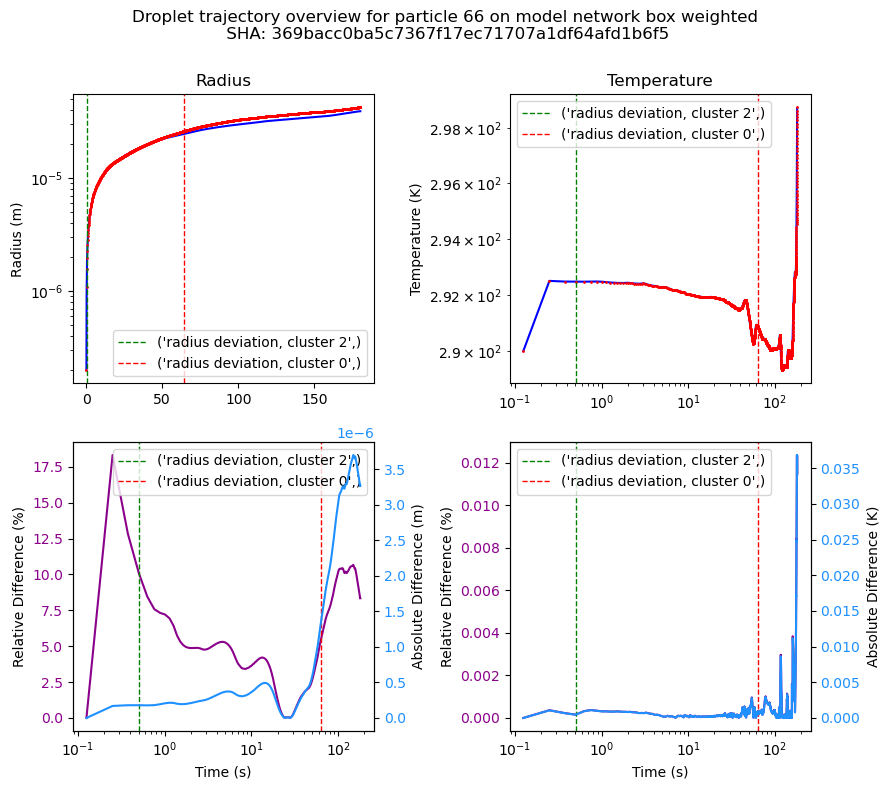

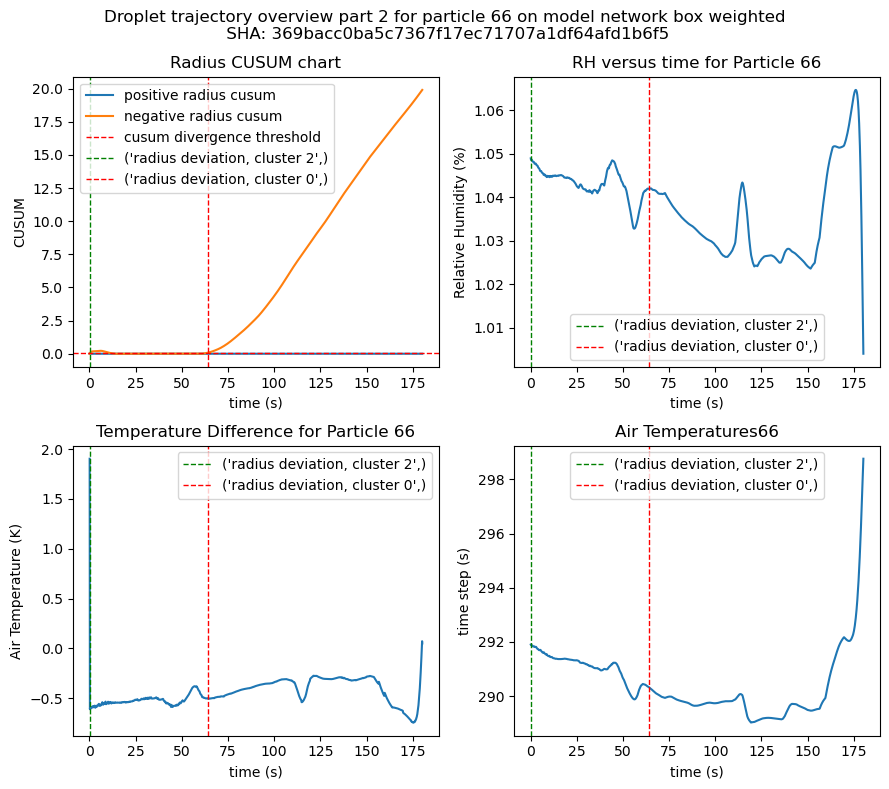

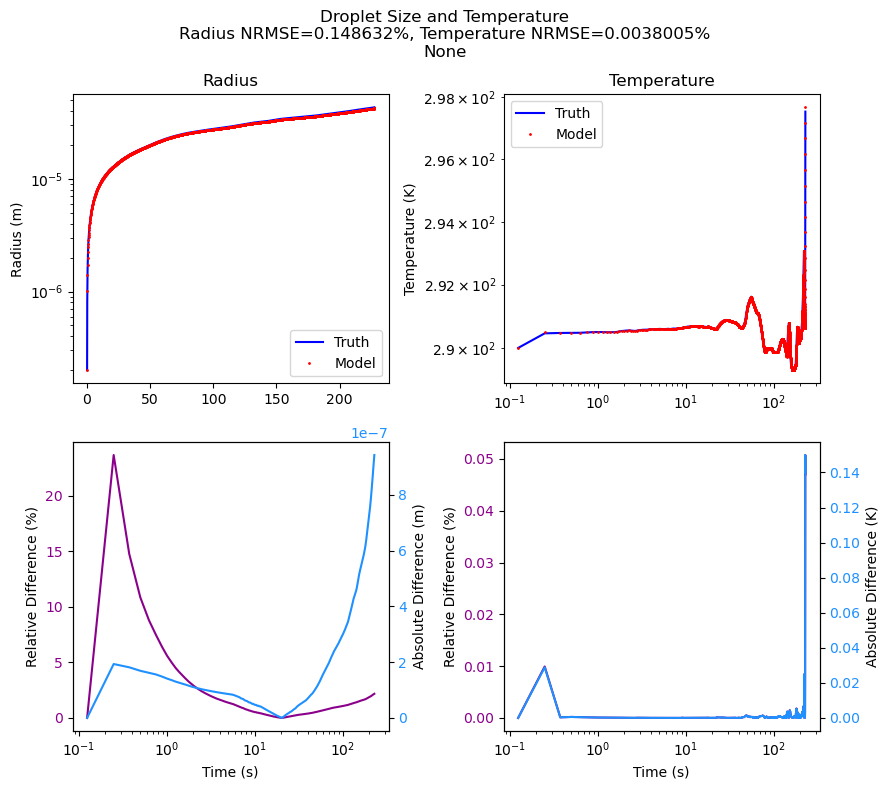

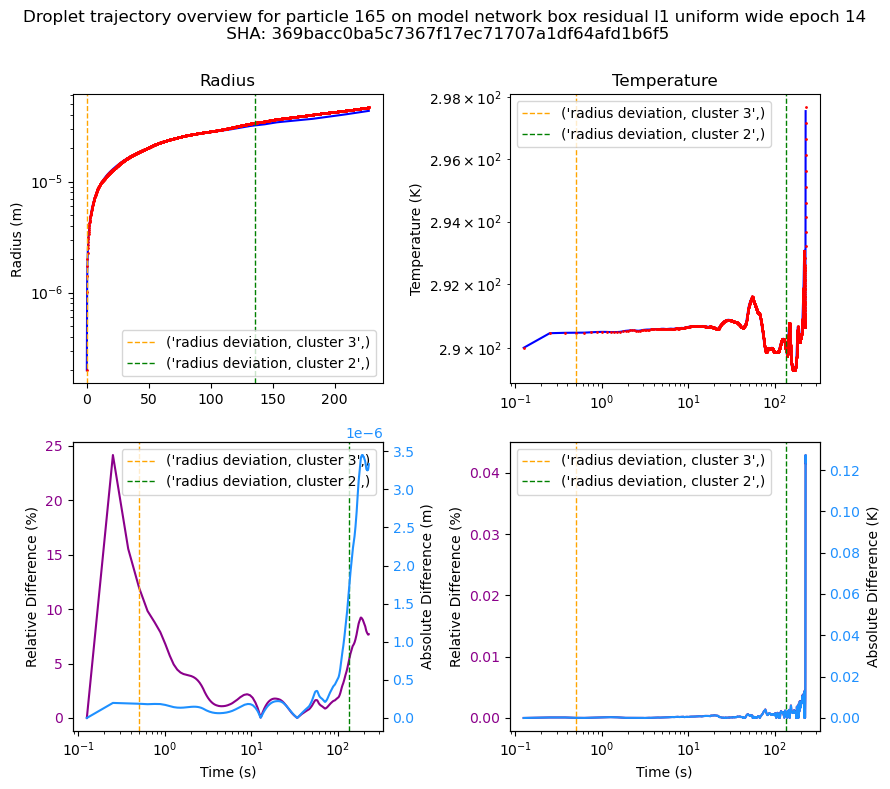

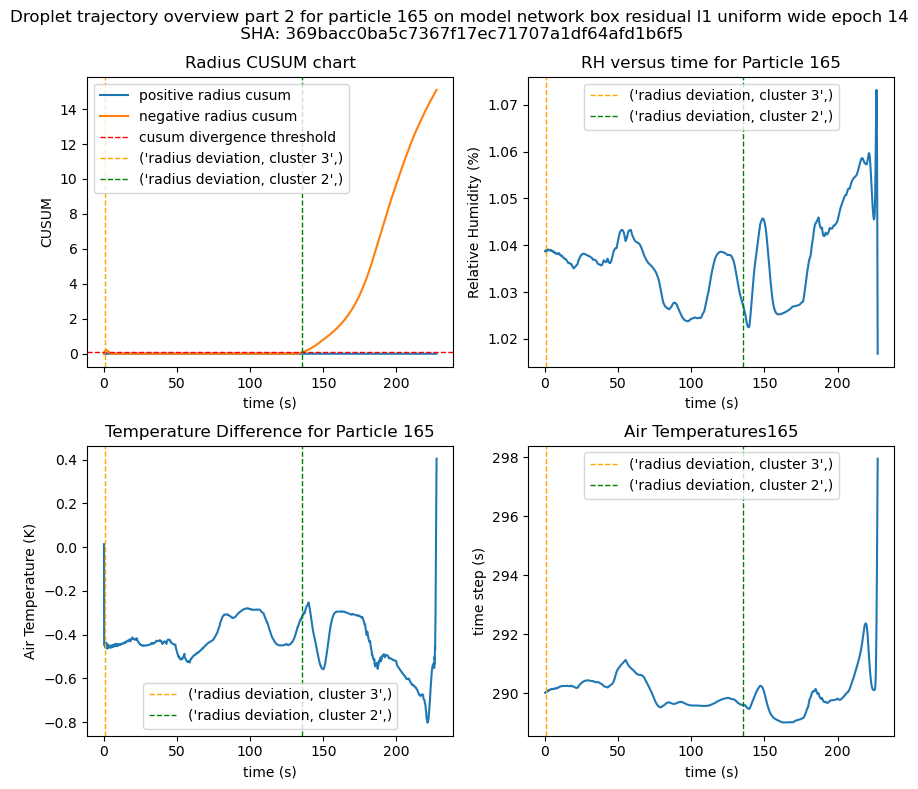

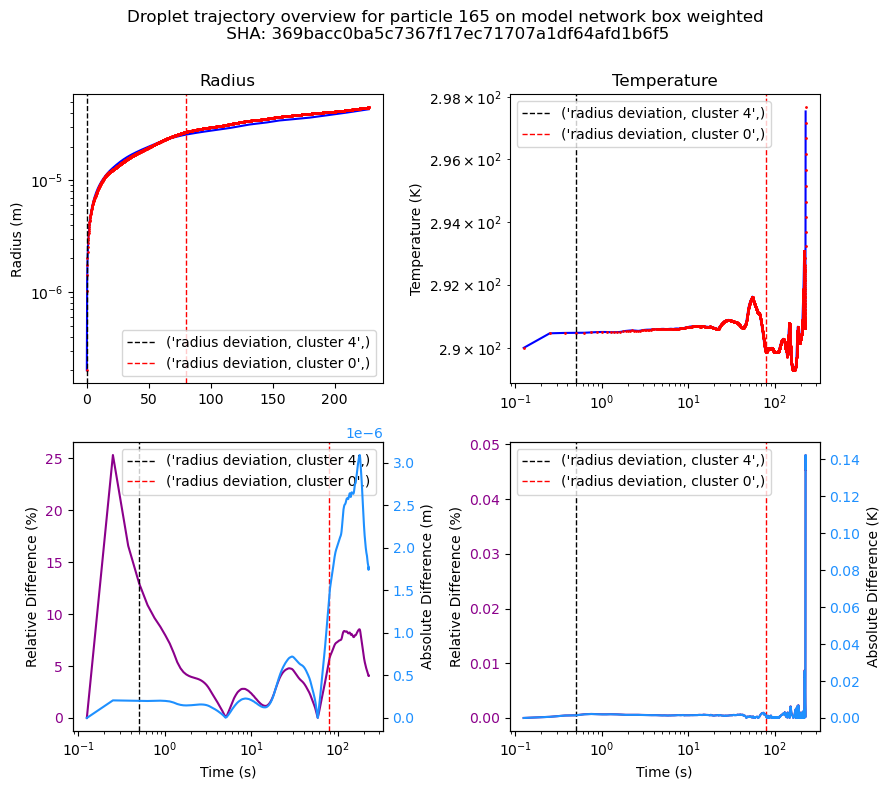

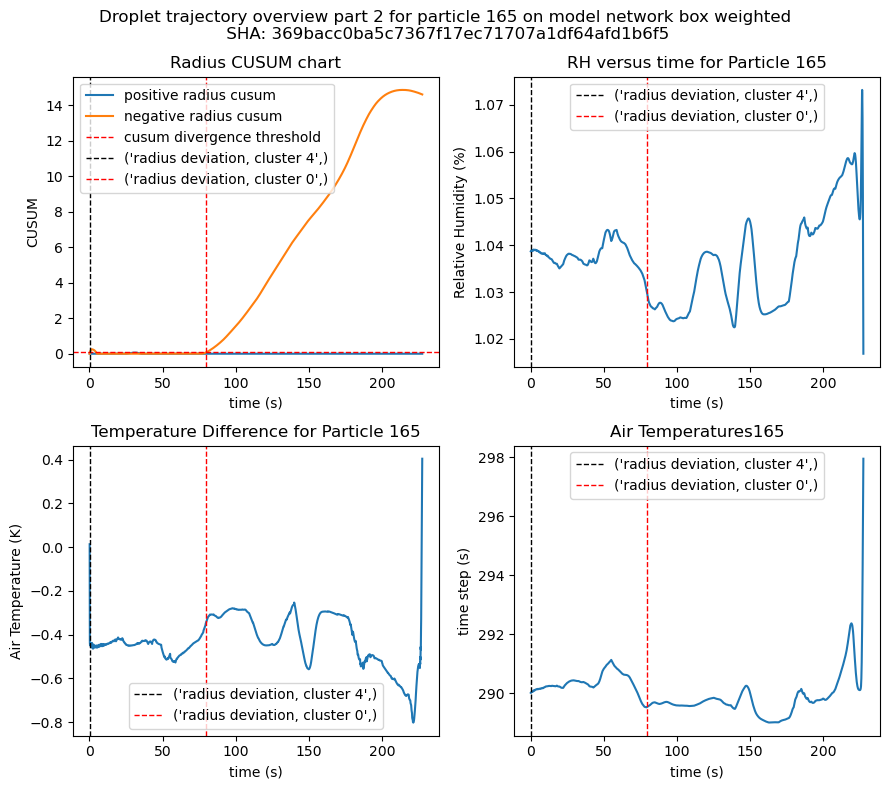

In [10]:
from matplotlib import colors


colormap = colors.ListedColormap( ["red", "blue", "green", "orange", "black", "yellow"] )

for i in df[(df["nrmse"] >= df["nrmse"].quantile(0.98))].index:
    particle_df = df.loc[i]
    input_parameters = np.stack(particle_df[[
        "input radii",
        "input temperatures",
        "salt masses",
        "air temperatures",
        "relative humidities",
        "air densities"
    ]].to_numpy(), axis=-1)


    integration_times = particle_df["integration times"]

    mask = be_success_mask( input_parameters[:, 0] )

    input_parameters = input_parameters[mask]
    integration_times= integration_times[mask]

    times = np.cumsum( integration_times )

    if iterative:
        model_outputs = [ do_iterative_inference(
                                input_parameters, 
                                times,
                                models[j],
                                "cpu"
                            ) for j in range( model_count ) ]
    else:
        model_outputs = [ np.insert( 
                                    do_inference(
                                        input_parameters, 
                                        integration_times,
                                        models[j],
                                        "cpu"
                                    )[:-1, :],
                                    0, 
                                    input_parameters[0, :2],
                                    axis=0
                                ) for j in range( model_count ) ]


    truth_output = do_iterative_bdf(
        input_parameters,
        times
    )


    normed_model_outputs = [ norm( model_output ) for model_output in model_outputs ]
    normed_truth_output = norm( truth_output )
    normed_be_output = norm( input_parameters[:, :2] )

    model_distances = [ np.abs( normed_model_output - normed_be_output) for normed_model_output in normed_model_outputs]
    truth_distance = np.abs( normed_truth_output - normed_be_output)


    fig_h_be, ax_h_be = analyze_model_particle_performance(
        times,
        input_parameters[:, :2], 
        truth_output,
        truth_distance
    )


    ax_h_be[0][0].set_xscale("linear")
    #ax_h_be[0][0].set_yscale("linear")

    for j in range( model_count ): 
        fig_h_0, ax_h_0 = analyze_model_particle_performance(
            times,
            input_parameters[:, :2], 
            model_outputs[j],
            model_distances[j]
        )

        fig_h_0.suptitle( f"Droplet trajectory overview for particle {i} on model {model_names[j]}\n SHA: {commit_SHAs[j]}" ) 

        ax_h_0[0][0].set_xscale("linear")
        #ax_h_0[0][0].set_yscale("linear")

        fig_h, ax_h = plt.subplots( 2, 2, figsize=(9,8))
        fig_h.tight_layout()
        fig_h.suptitle(f"Droplet trajectory overview part 2 for particle {i} on model {model_names[j]}\n SHA: {commit_SHAs[j]}" ) 

        model_cusum = np.abs( calculate_cusum( ( normed_be_output - normed_model_outputs[j] ).T[0], cusum_error_tolerance[0] ) )

        ax_h[0][0].set_title("Radius CUSUM chart") 
        ax_h[0][0].plot( times, model_cusum.T, label=["positive radius cusum", "negative radius cusum"] )
        ax_h[0][0].set_xlabel("time (s)")
        ax_h[0][0].axhline(y=cusum_error_threshold[0], color="red",linewidth=1, linestyle="--",label="cusum divergence threshold")

        ax_h[0][0].set_ylabel("CUSUM")

        ax_h[0][1].plot(times, particle_df["relative humidities"][mask])
        ax_h[0][1].set_title("RH versus time for Particle " + str(i))
        ax_h[0][1].set_xlabel("time (s)")
        ax_h[0][1].set_ylabel("Relative Humidity (%)") 


        ax_h[1][0].plot(times, particle_df["air temperatures"][mask] - particle_df["input temperatures"][mask])
        ax_h[1][0].set_title("Temperature Difference for Particle " + str(i))
        ax_h[1][0].set_xlabel("time (s)")
        ax_h[1][0].set_ylabel("Air Temperature (K)") 

        ax_h[1][1].plot(times, particle_df["air temperatures"][mask])
        ax_h[1][1].set_title("Air Temperatures" + str(i))
        ax_h[1][1].set_xlabel("time (s)")
        ax_h[1][1].set_ylabel("time step (s)") 

        for k, deviation_index in enumerate( np.where( score_reports[j].deviation_particle_ids == i ) ):
            for deviation_parameter, deviation_time, deviation_cluster in zip( score_reports[j].deviation_parameters[deviation_index], score_reports[j].deviation_times[deviation_index], score_reports[j].deviation_clusters[deviation_index] ):
                line_label = f"{deviation_parameter.name.lower()} deviation, cluster {deviation_cluster}", 

                ax_h_0[0][0].axvline(x=deviation_time,linewidth=1, linestyle="--", label=line_label, color=colormap( deviation_cluster ) )
                ax_h_0[0][1].axvline(x=deviation_time,linewidth=1, linestyle="--", label=line_label, color=colormap( deviation_cluster ) )
                ax_h_0[1][0].axvline(x=deviation_time,linewidth=1, linestyle="--", label=line_label, color=colormap( deviation_cluster ) )
                ax_h_0[1][1].axvline(x=deviation_time,linewidth=1, linestyle="--", label=line_label, color=colormap( deviation_cluster ) )
                
                ax_h[0][0].axvline(x=deviation_time, linewidth=1, linestyle="--", label=line_label, color=colormap( deviation_cluster ) )
                ax_h[0][1].axvline(x=deviation_time, linewidth=1, linestyle="--", label=line_label, color=colormap( deviation_cluster ) )
                ax_h[1][0].axvline(x=deviation_time, linewidth=1, linestyle="--", label=line_label, color=colormap( deviation_cluster ) )
                ax_h[1][1].axvline(x=deviation_time, linewidth=1, linestyle="--", label=line_label, color=colormap( deviation_cluster ) )

        ax_h[0][0].legend()
        ax_h[0][1].legend()
        ax_h[1][0].legend()
        ax_h[1][1].legend()

        ax_h_0[0][0].legend()
        ax_h_0[0][1].legend()
        ax_h_0[1][0].legend()
        ax_h_0[1][1].legend()

        fig_h.tight_layout()
        fig_h.show()
